In [ ]:
from autocvd import autocvd
autocvd(num_gpus = 1)
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7'
# os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import matplotlib.pyplot as plt

import jax.random as jr

from unxt import Quantity
import galax.coordinates as gc
import galax.potential as gp
import galax.dynamics as gd

# import agama

import time

The first run is slow. This is a feature of JIT.


/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax_test_backward/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


Elapsed time: 18.798654556274414 seconds
The second run should be much faster.


/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax_test_backward/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


Elapsed time: 1.9335896968841553 seconds


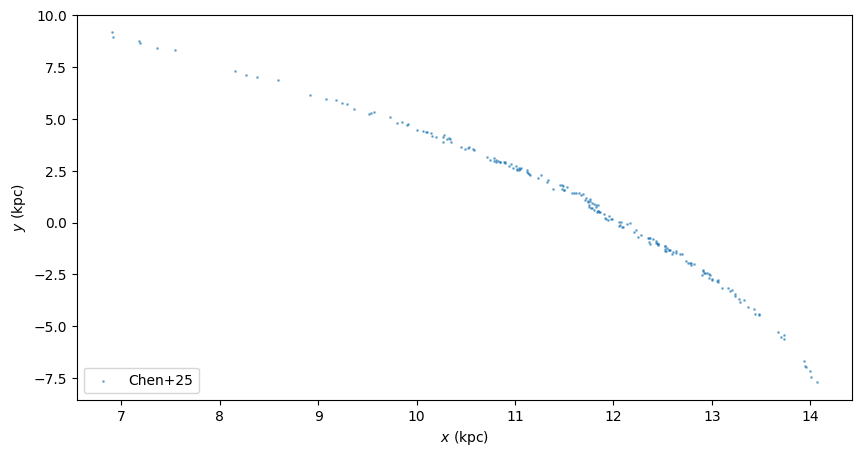

In [ ]:
pot = gp.BovyMWPotential2014()

w = gc.PhaseSpacePosition(q=Quantity([11.8, 0.79, 6.4], "kpc"),
                            p=Quantity([109.5,-254.5,-90.3], "km/s"),
                        )

t_array = Quantity(-np.linspace(0, 3000, 1_00), "Myr")
prog_mass = Quantity(10**4.05, "Msun")
print("The first run is slow. This is a feature of JIT.")

# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
start = time.time()
gen.run(jr.key(0), t_array, w, prog_mass)
end = time.time()
print(f"Elapsed time: {end - start} seconds")

print("The second run should be much faster.")

# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
start = time.time()
gen.run(jr.key(0), t_array, w, prog_mass)
end = time.time()
print(f"Elapsed time: {end - start} seconds")

fig = plt.figure(figsize=(10, 5))
stream_c25, prog_c25 = gen.run(jr.key(0), t_array, w, prog_mass)
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, label="Chen+25", alpha=0.5)
plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(loc='lower left')
# plt.savefig('./plot/particlespray_chen25/stream_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
import jax.numpy as jnp
import jax
from astropy import units as u

@jax.jit
def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from simulation frame to cartesian frame centred at Sun
    Args:
      Xhalo: 3d position (x [kpc], y [kpc], z [kpc]) in simulation frame
    Returns:
      3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Examples
    --------
    >>> halo_to_sun(jnp.array([1.0, 2.0, 3.0]))
    """
    sunx = 8.0
    xsun = sunx - Xhalo[0]
    ysun = Xhalo[1]
    zsun = Xhalo[2]
    return jnp.array([xsun, ysun, zsun])


@jax.jit
def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from sun cartesian frame to galactic co-ordinates
    Args:
      Xsun: 3d position (x_s [kpc], y_s [kpc], z_s [kpc]) in Sun frame
    Returns:
      3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Examples
    --------
    >>> sun_to_gal(jnp.array([1.0, 2.0, 3.0]))
    """
    r = jnp.linalg.norm(Xsun)
    b = jnp.arcsin(Xsun[2] / r)
    l = jnp.arctan2(Xsun[1], Xsun[0])
    return jnp.array([r, b, l])


@jax.jit
def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
    """
    Conversion from galactic co-ordinates to equatorial co-ordinates
    Args:
      Xgal: 3d position (r [kpc], b [rad], l [rad]) in galactic frame
    Returns:
      3d position (r [kpc], alpha [rad], delta [rad]) in equatorial frame
    Examples
    --------
    >>> gal_to_equat(jnp.array([1.0, 2.0, 3.0]))
    """
    dNGPdeg = 27.12825118085622
    lNGPdeg = 122.9319185680026
    aNGPdeg = 192.85948
    dNGP = dNGPdeg * jnp.pi / 180.0
    lNGP = lNGPdeg * jnp.pi / 180.0
    aNGP = aNGPdeg * jnp.pi / 180.0
    r = Xgal[0]
    b = Xgal[1]
    l = Xgal[2]
    sb = jnp.sin(b)
    cb = jnp.cos(b)
    sl = jnp.sin(lNGP - l)
    cl = jnp.cos(lNGP - l)
    cs = cb * sl
    cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
    alpha = jnp.arctan(cs / cc) + aNGP
    delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
    return jnp.array([r, alpha, delta])


def transform_velocity(transform_fn, X, V):
    """
    Generic velocity transformation through coordinate mapping.

    Args:
      transform_fn: function R^3 → R^3 mapping positions to new coordinates
      X: position vector in original coordinates (3,)
      V: velocity vector in original coordinates (3,)

    Returns:
      velocity vector in transformed coordinates (3,)
    """
    J = jax.jacobian(transform_fn)(X)  # (3,3) Jacobian
    return J @ V

def halo_to_equatorial(Xhalo):
    Xsun = halo_to_sun(Xhalo)
    Xgal = sun_to_gal(Xsun)
    Xeq  = gal_to_equat(Xgal)
    return Xeq


#vamp functions
halo_to_equatorial_batch = jax.vmap(halo_to_equatorial, in_axes=(0))
transform_velocity_batch = jax.vmap(transform_velocity, in_axes=(None, 0, 0))

def stream_to_array(stream):
    pos = jnp.array([stream.q.x.to('kpc').value, stream.q.y.to('kpc').value, stream.q.z.to('kpc').value])
    vel = jnp.array([stream.p.x.to('kpc/Myr').value, stream.p.y.to('kpc/Myr').value, stream.p.z.to('kpc/Myr').value])
    return jnp.concatenate([pos, vel], axis=0).T



In [ ]:
pot_new = gp.CompositePotential(
            disk=gp.BovyMWPotential2014.disk,
            halo=gp.BovyMWPotential2014.halo,
            bulge=gp.BovyMWPotential2014.bulge,
    )
# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot_new)

stream_c25, _ = gen.run(jr.key(0), t_array, w, prog_mass)
stream_target = stream_to_array(stream_c25)
pos_stream_target = stream_target[:, :3]
vel_stream_target = stream_target[:, 3:]
pos_eq_stream_target = halo_to_equatorial_batch(pos_stream_target)
vel_eq_stream_target = transform_velocity_batch(halo_to_equatorial, pos_stream_target, vel_stream_target)
stream_target = jnp.concatenate([pos_eq_stream_target, vel_eq_stream_target], axis=1)

def log_diag_multivariate_normal(x, mean, sigma_eff):
    """
    Log PDF of a multivariate Gaussian with diagonal covariance.
    sigma_eff : (D,)  # effective standard deviation per dimension
    """
    diff = (x - mean) / sigma_eff
    D = x.shape[0]
    log_det = 2.0 * jnp.sum(jnp.log(sigma_eff))
    norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
    exponent = -0.5 * jnp.sum(diff**2)
    return norm_const + exponent


def stream_likelihood_diag(model_stream, obs_stream, obs_errors, smooth_sigma):
    """
    Log-likelihood of observed stars given simulated stream (diagonal covariance),
    including model smoothing variance term Σ_k^2.
    
    Parameters
    ----------
    model_stream : (K, D)
    obs_stream : (N, D)
    obs_errors : (D,) or (N, D)
    smooth_sigma : (D,)  # per-dimension smoothing std deviation
    """
    sigma_eff = jnp.sqrt(obs_errors**2 + smooth_sigma**2)

    def obs_log_prob(obs):
        def model_log_prob(model_point):
            return log_diag_multivariate_normal(obs, model_point, sigma_eff)
        log_probs = jax.vmap(model_log_prob)(model_stream)
        log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
        return log_p_stream

    logL_values = jax.vmap(obs_log_prob)(obs_stream)
    return jnp.sum(logL_values)  # sum, not mean


@jax.jit
def log_multivariate_normal(x, mean, cov):
    """
    Log PDF of a multivariate Gaussian with full covariance.

    Parameters
    ----------
    x : (D,)
    mean : (D,)
    cov : (D, D)  # covariance matrix (must be symmetric positive definite)
    """
    D = x.shape[0]
    L = jnp.linalg.cholesky(cov)
    diff = x - mean
    solve = jax.scipy.linalg.solve_triangular(L, diff, lower=True)
    mahal = jnp.sum(solve**2)
    log_det = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
    norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
    return norm_const - 0.5 * mahal


@jax.jit
def stream_likelihood_fullcov(model_stream, obs_stream, obs_errors, smooth_sigma, ):
    """
    Log-likelihood of observed stars given simulated stream (full covariance version).
    """
    cov = smooth_sigma

    def obs_log_prob(obs):
        def model_log_prob(model_point):
            return log_multivariate_normal(obs, model_point, cov)
        log_probs = jax.vmap(model_log_prob)(model_stream)
        return jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])

    logL_values = jax.vmap(obs_log_prob)(obs_stream)
    return jnp.sum(logL_values)

@jax.jit
def loss(m_tot):
    pot_new = gp.CompositePotential(
            disk=gp.BovyMWPotential2014.disk,
            halo=gp.NFWPotential(m=m_tot, r_s=gp.BovyMWPotential2014.halo.r_s.value.value, units="galactic"),
            bulge=gp.BovyMWPotential2014.bulge,
    )
    w = gc.PhaseSpacePosition(q=Quantity([11.8, 0.79, 6.4], "kpc"),
                                p=Quantity([109.5,-254.5,-90.3], "km/s"),
                            )
    t_array = Quantity(-jnp.linspace(0, 3000, 10_000), "Myr")
    df = gd.ChenStreamDF()
    gen = gd.MockStreamGenerator(df, pot_new)
    stream_c25_new, prog_c25_new = gen.run(jr.key(0), t_array, w, prog_mass)

    stream = stream_to_array(stream_c25_new)
    stream_pos = stream[:, :3]
    stream_vel = stream[:, 3:]
    stream_eq_pos = halo_to_equatorial_batch(stream_pos)
    stream_eq_vel = transform_velocity_batch(halo_to_equatorial, stream_pos, stream_vel)
    stream = jnp.concatenate([stream_eq_pos, stream_eq_vel], axis=1)

    # noise_std = jnp.array([0.5, 0.5, 0.5, 0.001, 0.01, 0.01])  # example uncertainties in kpc and km/s
    noise_std = jnp.zeros(6)  # no observational errors
    pos_std = jnp.std(stream[:, :3] , axis=0)  # kpc
    vel_std = jnp.std(stream[:, 3:] , axis=0)  # km/s
    # smooth_sigma = jnp.concatenate([
    #     0.05 * pos_std,  # 5% of spatial dispersion
    #     0.05 * vel_std,  # 5% of velocity dispersion
    # ])
    # smooth_sigma = jnp.std(stream_target , axis=0) * 0.05  # 1% of target stream dispersion
    # return stream_likelihood_diag(model_stream=stream,
    #                          obs_stream=stream_target,
    #                          obs_errors=noise_std,
    #                          smooth_sigma=smooth_sigma)

    stream_cov = 0.1 *jnp.cov(stream_target.T)
    return stream_likelihood_fullcov(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std,
                             smooth_sigma=stream_cov)

mass_MN = jnp.sort(jnp.concatenate([jnp.linspace(gp.BovyMWPotential2014.halo.m.value.value* 0.5, gp.BovyMWPotential2014.halo.m.value.value* 1.5, 499), jnp.array([gp.BovyMWPotential2014.halo.m.value.value])]))
# loss_func = jax.block_until_ready(jax.jit(jax.vmap(loss)))
# loss_value = loss_func(mass_MN)
loss_value = jax.lax.map(loss, mass_MN, batch_size=100) 

/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax_test_backward/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


In [5]:
# import jax
# import jax.numpy as jnp

# # ---------- your forward functions (as given) ----------
# @jax.jit
# def halo_to_sun(Xhalo: jnp.ndarray) -> jnp.ndarray:
#     sunx = 8.0
#     xsun = sunx - Xhalo[0]
#     ysun = Xhalo[1]
#     zsun = Xhalo[2]
#     return jnp.array([xsun, ysun, zsun])

# @jax.jit
# def sun_to_gal(Xsun: jnp.ndarray) -> jnp.ndarray:
#     r = jnp.linalg.norm(Xsun)
#     b = jnp.arcsin(Xsun[2] / r)
#     l = jnp.arctan2(Xsun[1], Xsun[0])
#     return jnp.array([r, b, l])

# @jax.jit
# def gal_to_equat(Xgal: jnp.ndarray) -> jnp.ndarray:
#     # constants you used
#     dNGPdeg = 27.12825118085622
#     lNGPdeg = 122.9319185680026
#     aNGPdeg = 192.85948
#     dNGP = dNGPdeg * jnp.pi / 180.0
#     lNGP = lNGPdeg * jnp.pi / 180.0
#     aNGP = aNGPdeg * jnp.pi / 180.0

#     r = Xgal[0]
#     b = Xgal[1]
#     l = Xgal[2]
#     sb = jnp.sin(b)
#     cb = jnp.cos(b)
#     sl = jnp.sin(lNGP - l)
#     cl = jnp.cos(lNGP - l)
#     cs = cb * sl
#     cc = jnp.cos(dNGP) * sb - jnp.sin(dNGP) * cb * cl
#     # note: original used arctan(cs/cc) + aNGP
#     alpha = jnp.arctan(cs / cc) + aNGP
#     delta = jnp.arcsin(jnp.sin(dNGP) * sb + jnp.cos(dNGP) * cb * cl)
#     return jnp.array([r, alpha, delta])

# # ---------- inverses & helpers ----------

# @jax.jit
# def gal_to_sun(Xgal: jnp.ndarray) -> jnp.ndarray:
#     """
#     Inverse of `sun_to_gal`: spherical galactic (r,b,l) -> cartesian Sun-frame (x_s,y_s,z_s)
#     """
#     r, b, l = Xgal[0], Xgal[1], Xgal[2]
#     cb = jnp.cos(b)
#     xs = r * cb * jnp.cos(l)
#     ys = r * cb * jnp.sin(l)
#     zs = r * jnp.sin(b)
#     return jnp.array([xs, ys, zs])

# @jax.jit
# def sun_to_halo(Xsun: jnp.ndarray) -> jnp.ndarray:
#     """
#     Inverse of halo_to_sun: Sun-frame -> halo-frame (simulation frame)
#     halo_to_sun did: xsun = sunx - Xhalo[0], ysun = Xhalo[1], zsun = Xhalo[2]
#     So invert:
#       Xhalo[0] = sunx - xsun
#       Xhalo[1] = ysun
#       Xhalo[2] = zsun
#     """
#     sunx = 8.0
#     xsun, ysun, zsun = Xsun[0], Xsun[1], Xsun[2]
#     xhalo = sunx - xsun
#     return jnp.array([xhalo, ysun, zsun])

# # We will derive the rotation matrix R (galactic -> equatorial) from your gal_to_equat function,
# # by mapping three canonical galactic unit vectors (l=0,b=0), (l=90°,b=0), (b=90°) through gal_to_equat
# # and converting to equatorial cartesian vectors. Then R @ v_g = v_e, so R^T maps back.

# @jax.jit
# def _construct_gal_to_equat_rotation():
#     # spherical positions for canonical galactic basis:
#     # e_g_x  : l = 0,      b = 0
#     # e_g_y  : l = pi/2,   b = 0
#     # e_g_z  : b = pi/2    (l arbitrary, choose 0)
#     p1 = jnp.array([1.0, 0.0, 0.0])            # r=1, b=0, l=0
#     p2 = jnp.array([1.0, 0.0, 0.5 * jnp.pi])   # r=1, b=0, l=90deg
#     p3 = jnp.array([1.0, 0.5 * jnp.pi, 0.0])   # r=1, b=90deg, l=0

#     # apply your gal_to_equat to each (result is [r, alpha, delta])
#     e1_eq = gal_to_equat(p1)
#     e2_eq = gal_to_equat(p2)
#     e3_eq = gal_to_equat(p3)

#     def spherical_equat_to_unit_vec(Xeq):
#         # Xeq is [r, alpha, delta] -> unit equatorial cartesian vector
#         alpha = Xeq[1]
#         delta = Xeq[2]
#         ce = jnp.cos(delta)
#         x = ce * jnp.cos(alpha)
#         y = ce * jnp.sin(alpha)
#         z = jnp.sin(delta)
#         return jnp.array([x, y, z])

#     v1 = spherical_equat_to_unit_vec(e1_eq)
#     v2 = spherical_equat_to_unit_vec(e2_eq)
#     v3 = spherical_equat_to_unit_vec(e3_eq)

#     # columns of R are images of galactic unit vectors in equatorial frame
#     R = jnp.stack([v1, v2, v3], axis=1)  # shape (3,3)
#     return R

# # Precompute rotation (jit-friendly)
# R_gal2equat = _construct_gal_to_equat_rotation()  # (3,3)
# R_equat2gal = R_gal2equat.T                      # inverse (since orthonormal)

# @jax.jit
# def equat_to_gal(Xeq: jnp.ndarray) -> jnp.ndarray:
#     """
#     Inverse of gal_to_equat: equatorial spherical (r, alpha, delta)
#     -> galactic spherical (r, b, l)
#     We convert to equatorial cartesian unit vector, map to galactic cartesian via R^T, then
#     get (b,l) from that.
#     """
#     r = Xeq[0]
#     alpha = Xeq[1]
#     delta = Xeq[2]

#     # unit vector in equatorial cartesian
#     ce = jnp.cos(delta)
#     v_e = jnp.array([ce * jnp.cos(alpha), ce * jnp.sin(alpha), jnp.sin(delta)])  # (3,)

#     # map to galactic cartesian unit vector
#     v_g = R_equat2gal @ v_e

#     # numerical safety: renormalize unit length
#     v_g = v_g / jnp.linalg.norm(v_g)

#     # spherical galactic coords
#     b = jnp.arcsin(v_g[2])
#     l = jnp.arctan2(v_g[1], v_g[0])
#     # put l in [0, 2pi)
#     l = jnp.mod(l, 2.0 * jnp.pi)

#     return jnp.array([r, b, l])

# @jax.jit
# def equat_to_halo(Xeq: jnp.ndarray) -> jnp.ndarray:
#     """
#     Full inverse: equatorial spherical (r, alpha, delta)
#     -> halo cartesian (x,y,z) in simulation frame
#     Steps: equat -> gal (r,b,l) -> gal spherical -> sun cartesian -> halo cartesian
#     """
#     Xgal = equat_to_gal(Xeq)        # (r, b, l)
#     Xsun = gal_to_sun(Xgal)         # (x_s, y_s, z_s)
#     Xhalo = sun_to_halo(Xsun)       # invert halo_to_sun
#     return Xhalo

# # Batched variants
# equat_to_halo_batch = jax.vmap(equat_to_halo, in_axes=(0,))
# equat_to_gal_batch = jax.vmap(equat_to_gal, in_axes=(0,))

# # velocity transform: convert a velocity in equatorial cartesian -> halo cartesian using Jacobian
# def transform_velocity_equat_to_halo(Xeq, Veq):
#     """
#     Transform velocities given position mapping equat -> halo.
#     Veq is velocity in equatorial-cartesian-like coordinates (units consistent).
#     Returns Vhalo = J @ Veq where J = jacobian(equat_to_halo)(Xeq)
#     """
#     J = jax.jacobian(equat_to_halo)(Xeq)  # (3,3)
#     return J @ Veq

# transform_velocity_equat_to_halo_batch = jax.vmap(transform_velocity_equat_to_halo, in_axes=(0, 0))


# # ---------------- quick numeric sanity check ----------------
# if __name__ == "__main__":
#     # pick a random halo point, map to equatorial and back
#     stream_target_pos_eq = stream_target[:, :3]
#     stream_target_vel_eq = stream_target[:, 3:]

#     X_cart = equat_to_halo_batch(stream_target_pos_eq)
#     V_cart = transform_velocity_equat_to_halo_batch(stream_target_pos_eq, stream_target_vel_eq)
    
#     # should be near zero within numerical tolerance
#     diff = X_cart - stream_to_array(stream_c25)[:, :3]
#     print("Position difference after round-trip (should be near zero):", diff)


In [ ]:
best_stream_param = mass_MN[jnp.argmax(loss_value)]

pot_best = gp.CompositePotential(
            disk=gp.BovyMWPotential2014.disk,
            halo=gp.NFWPotential(m=best_stream_param, r_s=gp.BovyMWPotential2014.halo.r_s.value.value, units="galactic"),
            bulge=gp.BovyMWPotential2014.bulge,
    )
# Chen+25 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot_best)
stream_c25_best, prog_c25_best = gen.run(jr.key(0), t_array, w, prog_mass)
stream_best = stream_to_array(stream_c25_best)
stream_pos = stream_best[:, :3]
stream_vel = stream_best[:, 3:]
stream_eq_pos = halo_to_equatorial_batch(stream_pos)
stream_eq_vel = transform_velocity_batch(halo_to_equatorial, stream_pos, stream_vel)
stream_best = jnp.concatenate([stream_eq_pos, stream_eq_vel], axis=1)

/export/home/vgiusepp/Odisseo/notebooks/dev/albastross/action_angle/galax_test_backward/src/galax/dynamics/_src/legacy/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


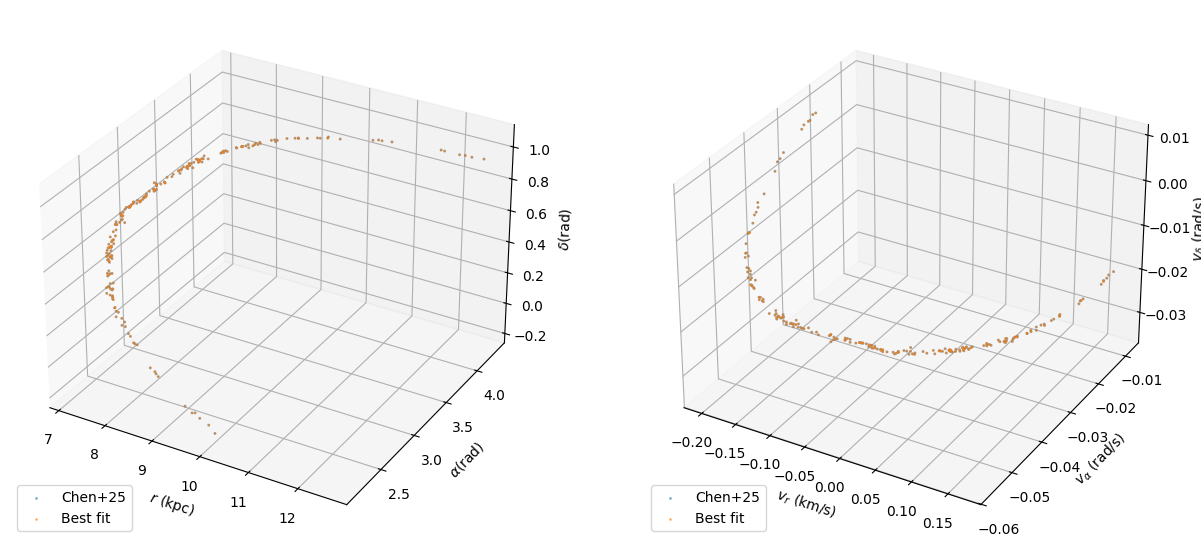

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(stream_target[:, 0], stream_target[:, 1], stream_target[:, 2], s=1, label="Chen+25", alpha=0.5)
ax.scatter(stream_best[:, 0], stream_best[:, 1], stream_best[:, 2], s=1, label="Best fit", alpha=0.5)

ax.set_xlabel(r'$r\ ({\rm kpc})$')
ax.set_ylabel(r'$\alpha ({\rm rad})$')
ax.set_zlabel(r'$\delta ({\rm rad})$')
ax.legend(loc='lower left')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(stream_target[:, 3], stream_target[:, 4], stream_target[:, 5], s=1, label="Chen+25", alpha=0.5)
ax.scatter(stream_best[:, 3], stream_best[:, 4], stream_best[:, 5], s=1, label="Best fit", alpha=0.5)
ax.set_xlabel(r'$v_r\ ({\rm km/s})$')
ax.set_ylabel(r'$v_\alpha\ ({\rm rad/s})$')
ax.set_zlabel(r'$v_\delta\ ({\rm rad/s})$')
ax.legend(loc='lower left')    

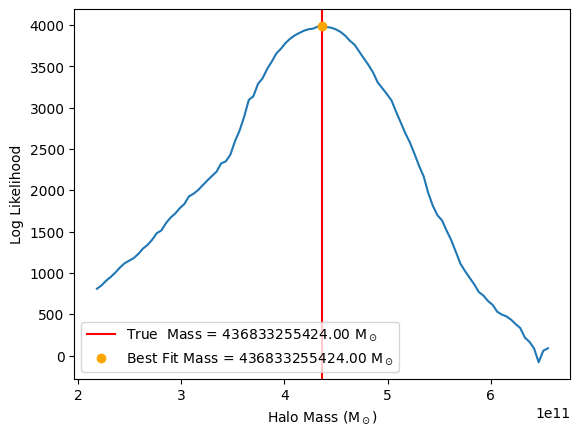

In [ ]:
plt.plot(mass_MN, loss_value)
plt.axvline(jnp.array(gp.BovyMWPotential2014.halo.m.value.value), label='True  Mass = {:.2f} M$_\odot$'.format(gp.BovyMWPotential2014.halo.m.value.value), color='r')
plt.scatter(best_stream_param, jnp.max(loss_value), color='orange', label='Best Fit Mass = {:.2f} M$_\odot$'.format(best_stream_param), zorder=5)
plt.xlabel('Halo Mass (M$_\odot$)')
plt.ylabel('Log Likelihood')
plt.legend()
plt.show()

In [9]:
grad_value = jax.lax.map(jax.grad(loss), mass_MN, batch_size=10)
# grad_value = grad_func(mass_MN) 

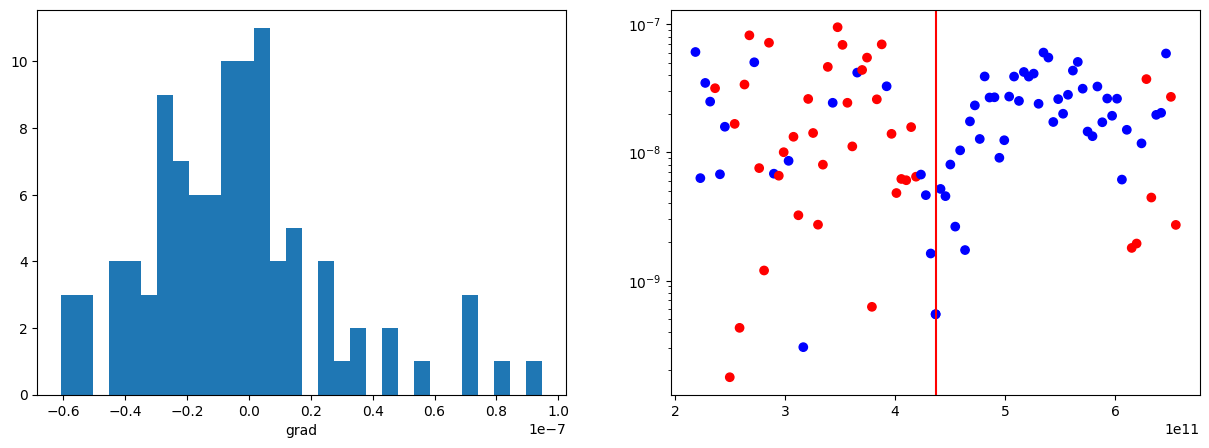

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist(grad_value, bins=30)
ax.set_xlabel('grad')

ax= fig.add_subplot(122)
ax.scatter(mass_MN, jnp.sqrt(grad_value**2), c=np.where(grad_value>0, 'r', 'b'))
ax.axvline(jnp.array(gp.BovyMWPotential2014.halo.m.value.value), color='r', label='True $M_{tot}$')
ax.set_yscale('log')


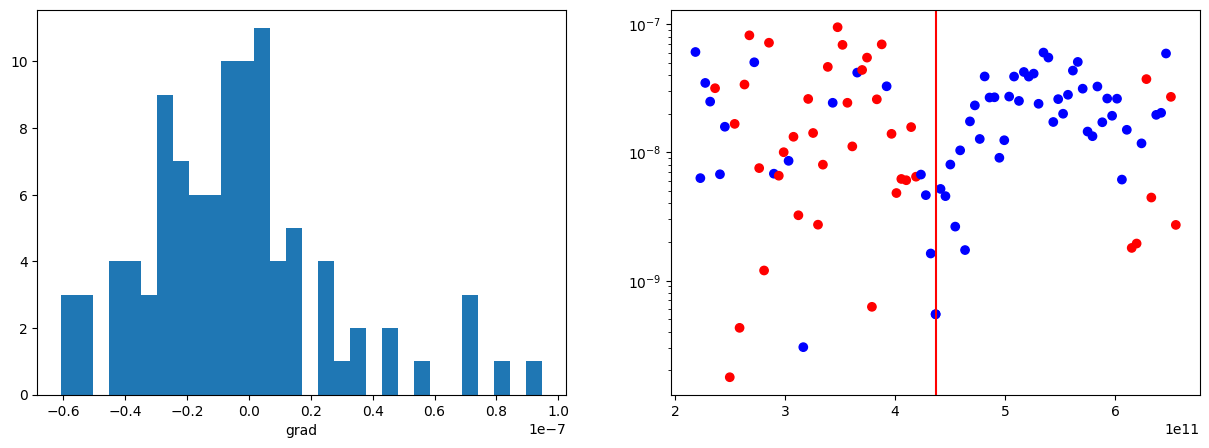

In [11]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist(grad_value, bins=30)
ax.set_xlabel('grad')

ax= fig.add_subplot(122)
ax.scatter(mass_MN, jnp.sqrt(grad_value**2), c=np.where(grad_value>0, 'r', 'b'))
ax.axvline(jnp.array(gp.BovyMWPotential2014.halo.m.value.value), color='r', label='True $M_{tot}$')
ax.set_yscale('log')


# Agama

In [19]:
actFinder?


Signature:   actFinder(*args, **kwargs)
Type:        ActionFinder
String form: AxisymmetricFudge(potential=CompositePotential{ MiyamotoNagai, Multipole })
File:        ~/miniconda3/envs/galax/lib/python3.11/site-packages/agama/__init__.py
Docstring:  
ActionFinder object is created for a given potential (provided as the first argument to the constructor); if the potential is axisymmetric, there is a further option to use interpolation tables for actions (optional second argument 'interp=...', False by default), which speeds up computation of actions (but not frequencies and angles) at the expense of a somewhat lower accuracy.
The () operator computes any combination of actions, angles and frequencies for a given position/velocity point or an array of points.
Arguments:
  point - a sextet of floats (x,y,z,vx,vy,vz) or an Nx6 array of N such sextets.
  actions (bool, default True) - whether to compute actions.
  angles (bool, default False) - whether to compute angles (extra work).
  fre

In [20]:
from astropy import units as u

2000


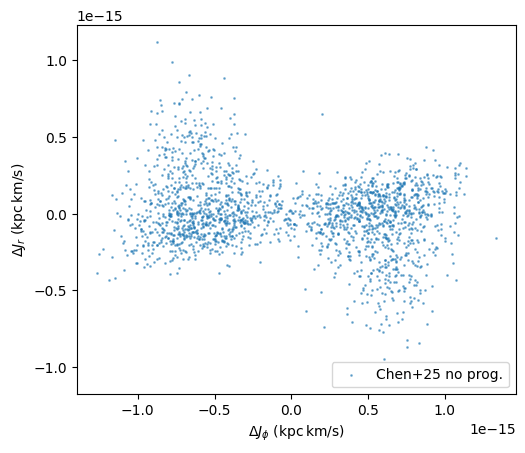

In [21]:
import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('./MWPotential2024.ini'))


def get_action(stream, prog, actFinder):
    pos_prog = np.array([prog.q.x.to('kpc').value, prog.q.y.to('kpc').value, prog.q.z.to('kpc').value])
    vel_prog = np.array([prog.p.x.to('km/s').value, prog.p.y.to('km/s').value, prog.p.z.to('km/s').value])
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog, angles_prog, freqs_prog = actFinder(posvel_prog, angles=True, )
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]

    pos = np.array([stream.q.x.to('kpc').value, stream.q.y.to('kpc').value, stream.q.z.to('kpc').value])
    vel = np.array([stream.p.x.to('km/s').value, stream.p.y.to('km/s').value, stream.p.z.to('km/s').value])
    posvel = np.column_stack((pos.T,vel.T))
    actions, angles, freqs = actFinder(posvel, angles=True, )
    print(len(actions))
    Jphi = actions[:,2]
    Jr = actions[:,0]
    last_J =actions[:, 1]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles_prog, angles,freqs_prog, freqs
    
# DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
# plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles_prog, angles, freqs_prog, freqs = get_action(stream_c25, prog_c25, actFinder)
plt.figure()
plt.scatter(DJphi * (u.kpc * u.km / u.s).to(u.kpc**2/u.s), DJr * (u.kpc * u.km / u.s).to(u.kpc**2/u.s), s=1, alpha=0.5, label='Chen+25 no prog.')
plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
# plt.xlim(-120, 120)
# plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.gca().set_aspect(1)
# plt.savefig('./plot/particlespray_chen25/stream_action_plot.png', dpi=300, bbox_inches='tight')
plt.show()



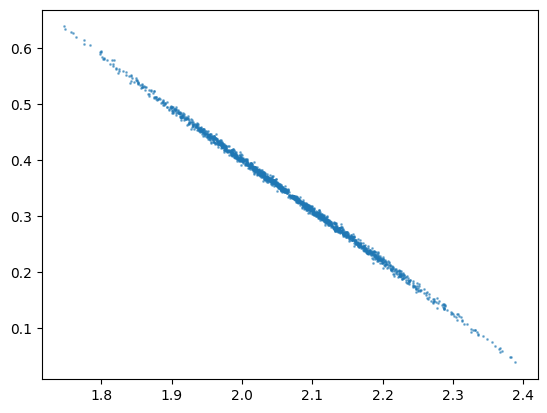

In [22]:
plt.scatter(angles[:,1], angles[:,2], s=1, alpha=0.5)

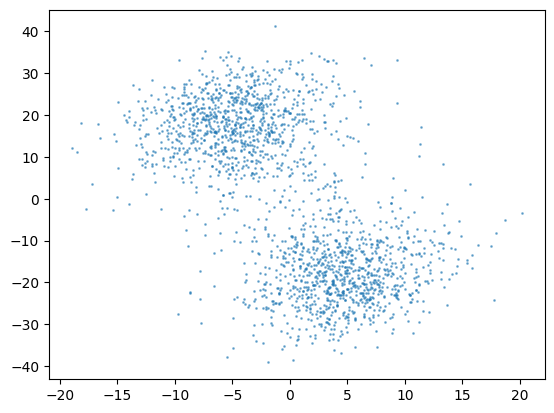

In [23]:
plt.scatter(actions[:,1]-action_prog[1], actions[:,2]-action_prog[2], s=1, alpha=0.5)

In [24]:
angles.shape

(2000, 3)

In [25]:
freqs.shape

(2000, 3)

In [26]:
angles_prog.shape

(3,)

In [27]:
angles_prog

array([0.11449431, 2.06683092, 0.33958366])

# No rotation 

In [28]:
angles[angles > np.pi ] = angles[angles > np.pi ] - 2 * np.pi

In [29]:
delta_angles = angles - angles_prog
# delta_angles = angles
delta_angles.shape


(2000, 3)

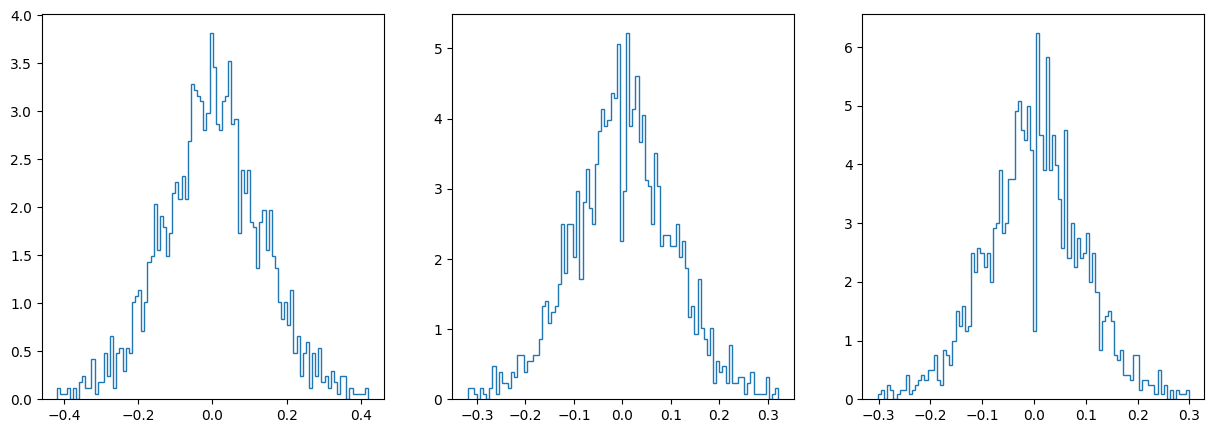

In [30]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(delta_angles[:,i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

delta_t:
[3.00062182 3.06810523 3.02504184 ... 0.00464367 0.02982988 0.02947213]
delta_alpha shape:
(2000, 3)


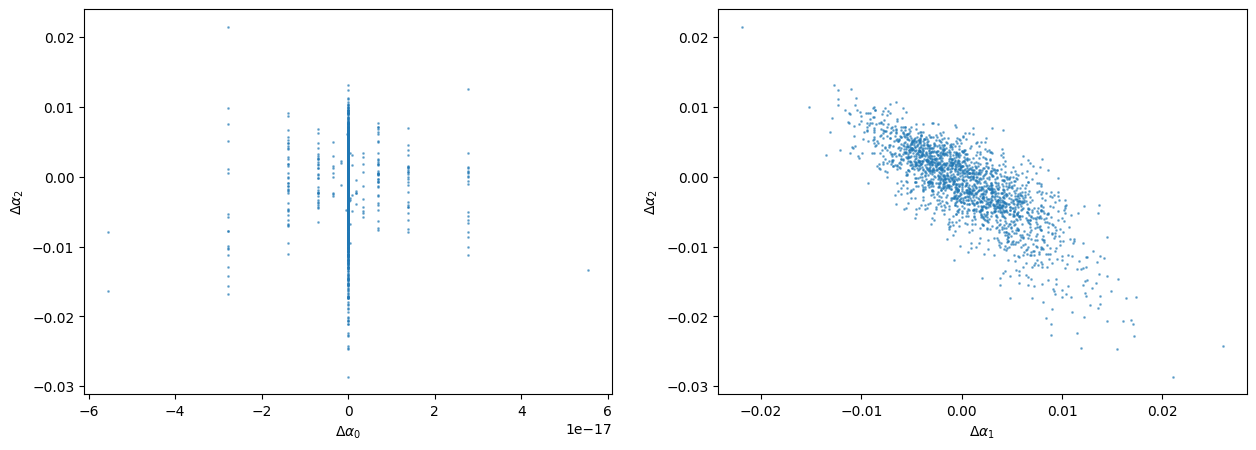

In [32]:
# I miss the rotation !


delta_angles = angles - angles_prog
delta_freqs = freqs - freqs_prog

# delta_t = np.linalg.norm(delta_angles, axis=1)/np.linalg.norm(delta_freqs, axis=1)
delta_t = delta_angles[:, 0]/delta_freqs[:, 0]
print('delta_t:')
print(delta_t)

delta_alpha = delta_angles - delta_freqs * delta_t[:, None]
print('delta_alpha shape:')
print(delta_alpha.shape)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121,)
ax.scatter(delta_alpha[:,0], delta_alpha[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_0$')
ax.set_ylabel(r'$\Delta \alpha_2$')

ax = fig.add_subplot(122,)
ax.scatter(delta_alpha[:,1], delta_alpha[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_1$')
ax.set_ylabel(r'$\Delta \alpha_2$')
plt.show() 


Text(0.5, 0, '$h = \\sqrt{\\Delta \\alpha_1^2 + \\Delta \\alpha_2^2}$')

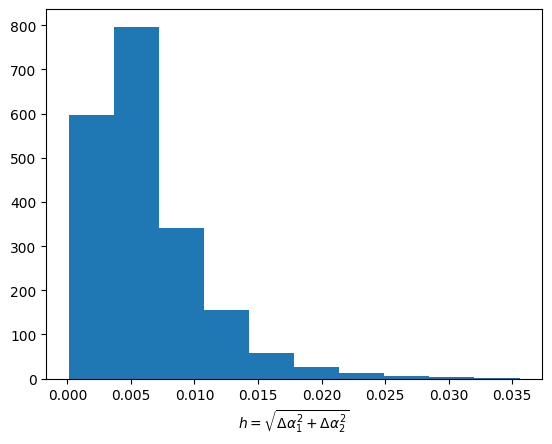

In [33]:
h = np.sqrt(delta_alpha[:, 1]**2 + delta_alpha[:, 2]**2)
plt.hist(h )
plt.xlabel(r'$h = \sqrt{\Delta \alpha_1^2 + \Delta \alpha_2^2}$')

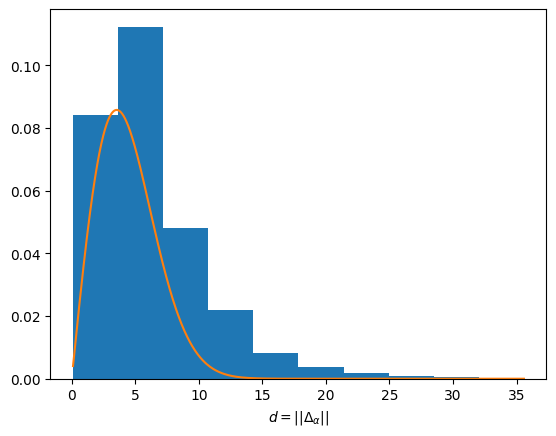

In [46]:
d = np.linalg.norm(delta_alpha * 1000, axis=1) 
plt.hist(d, density=True , bins=10);
plt.xlabel(r'$d = ||\Delta_\alpha||$')
x = np.sort(d)
sigma = 5
plt.plot(x,  x/sigma**2 * np.exp(-x**2/sigma**2))
# plt.xlim(0, 0.1)

/tmp/ipykernel_1626195/633850117.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')



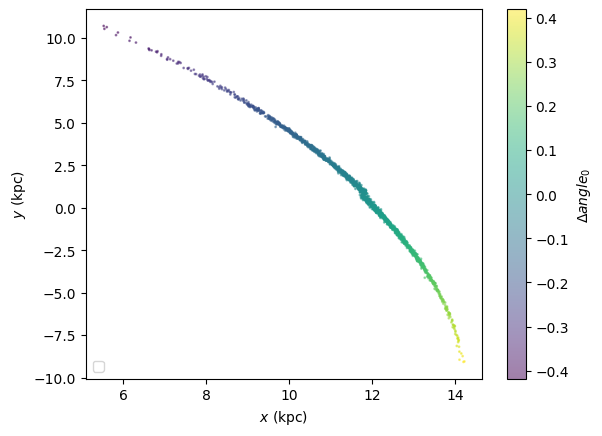

In [47]:
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, c=(angles[:, 0] - angles_prog[0]), alpha=0.5)
plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(loc='lower left')
plt.colorbar(label=r'$\Delta angle_0$')
# plt.savefig('./plot/particlespray_chen25/stream_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# With rotation

In [48]:
import numpy as np
from scipy.stats import differential_entropy
from scipy.optimize import minimize
from scipy.special import erfinv
def rotation_matrix(phi_r, phi_phi, phi_z):
    """Return combined rotation matrix R = Rr Rphi Rz."""
    cr, sr = np.cos(phi_r), np.sin(phi_r)
    cphi, sphi = np.cos(phi_phi), np.sin(phi_phi)
    cz, sz = np.cos(phi_z), np.sin(phi_z)

    Rr = np.array([[1, 0, 0],
                   [0, cr, -sr],
                   [0, sr, cr]])

    Rphi = np.array([[cphi, 0, sphi],
                     [0, 1, 0],
                     [-sphi, 0, cphi]])

    Rz = np.array([[cz, -sz, 0],
                   [sz, cz, 0],
                   [0, 0, 1]])

    return Rr @ Rphi @ Rz  # Equation (F1)


def entropy_objective(angles, dJ, dOmega):
    """Objective to minimize: sum of entropies h(φ | Λ_j)."""
    R = rotation_matrix(*angles)
    dJp = dJ @ R.T
    dOp = dOmega @ R.T

    # Avoid division issues
    mask = np.all(np.abs(dJp) > 1e-8, axis=1)
    dJp, dOp = dJp[mask], dOp[mask]

    Lambda = dOp / dJp  # shape (N, 3)
    entropies = [differential_entropy(Lambda[:, j]) for j in range(3)]
    return np.sum(entropies)


def estimate_hessian_rotation(J, Omega, J0=None, Omega0=None):
    """
    Estimate Hessian eigenvalues and rotation angles from an N-body stream.
    Based on Appendix F of the paper.
    """
    J = np.asarray(J)
    Omega = np.asarray(Omega)
    if J0 is None:
        J0 = np.median(J, axis=0)
    if Omega0 is None:
        Omega0 = np.median(Omega, axis=0)

    dJ = J - J0
    dOmega = Omega - Omega0

    # Minimize entropy sum over angles in [0, π/2)
    bounds = [(0, np.pi/2)] * 3
    res = minimize(entropy_objective, x0=[0.3, 0.3, 0.3],
                   args=(dJ, dOmega), bounds=bounds)

    phi_hat = res.x
    R_opt = rotation_matrix(*phi_hat)

    # Compute final ratios Λ_j and eigenvalue medians
    dJp = dJ @ R_opt.T
    dOp = dOmega @ R_opt.T
    Lambda = dOp / dJp

    lambda_hat = np.median(Lambda, axis=0)

    # Median Absolute Deviation as uncertainty
    c = 1 / (np.sqrt(2) * erfinv(0.5))
    mad = c * np.median(np.abs(Lambda - lambda_hat), axis=0)

    return {
        "phi_hat": phi_hat,
        "lambda_hat": lambda_hat,
        "mad": mad,
        "success": res.success,
        "message": res.message,
    }

result = estimate_hessian_rotation(J=actions, Omega=freqs, J0=action_prog, Omega0=freqs_prog)
result


{'phi_hat': array([0.16458823, 0.87188141, 0.16328863]),
 'lambda_hat': array([ 0.00015802, -0.00973991, -0.00520076]),
 'mad': array([4.29876921e-05, 4.68599394e-03, 1.70521355e-03]),
 'success': True,
 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH'}

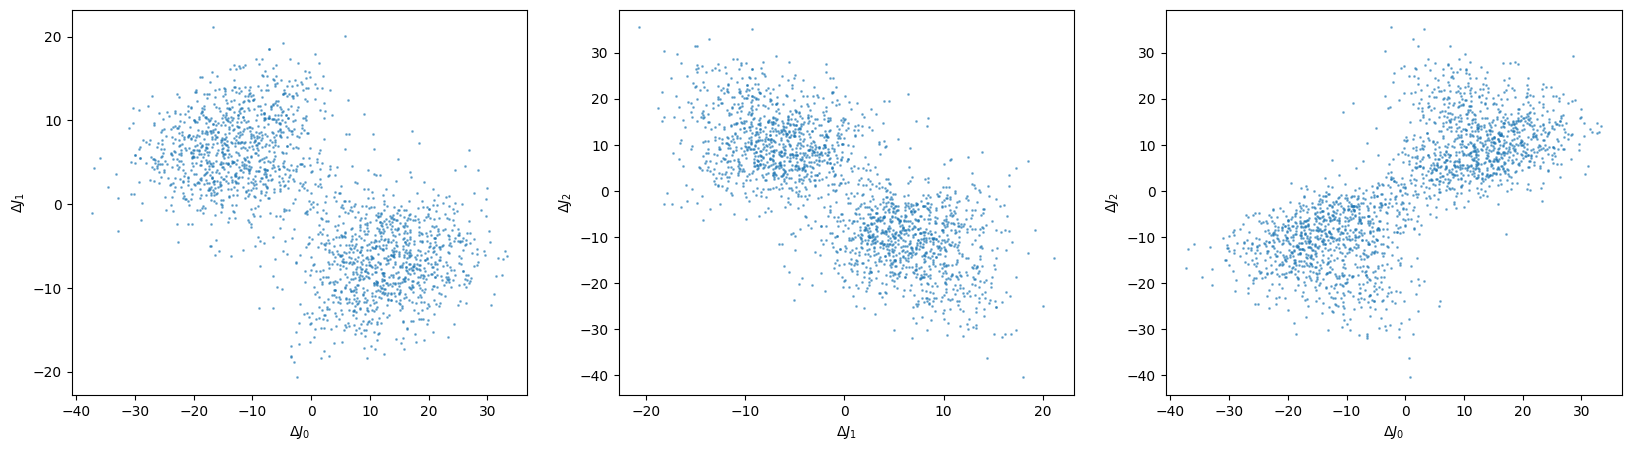

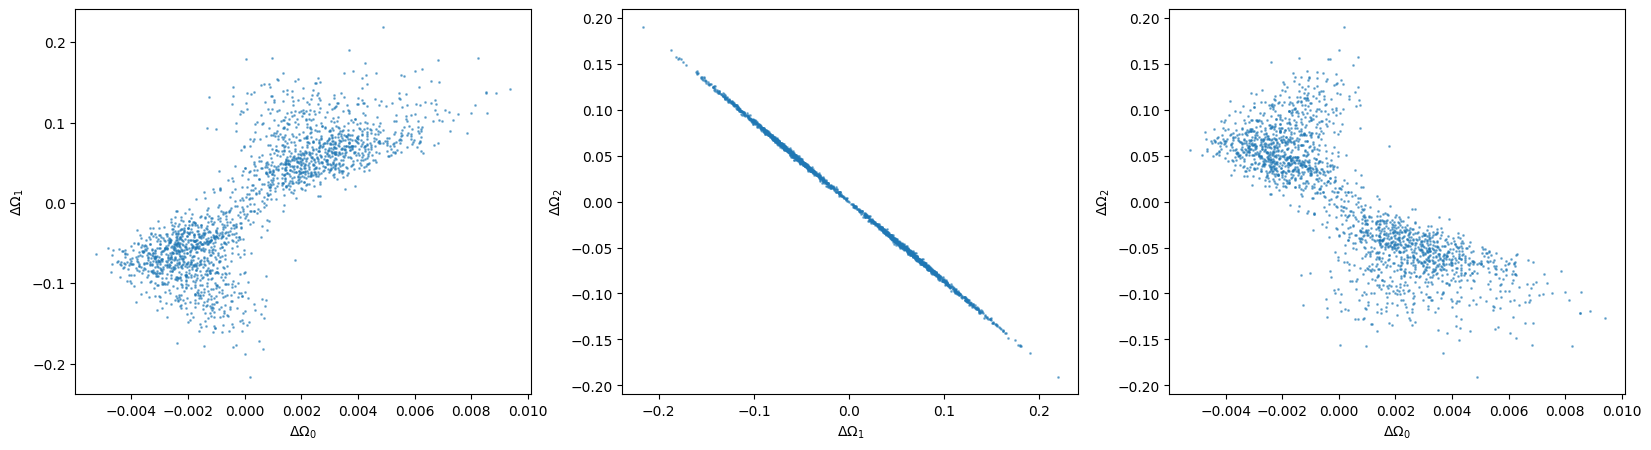

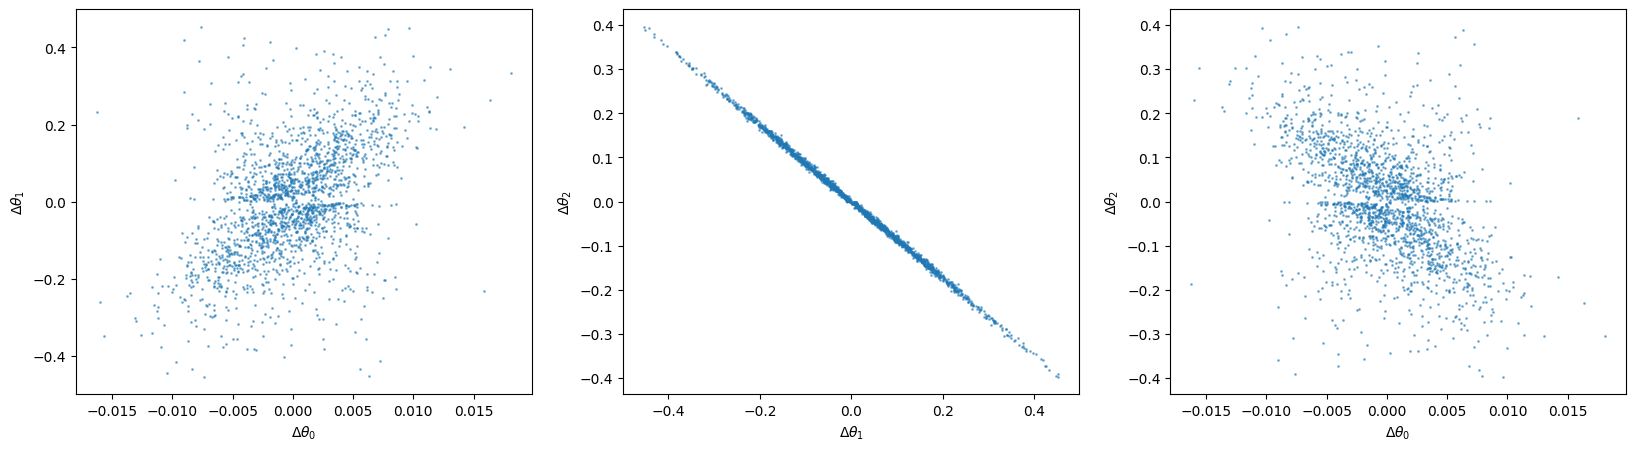

In [49]:
R_opt = rotation_matrix(*result['phi_hat'])

def rotate_actions_angles(J, Omega, theta, phi_hat):
    """
    Rotate actions, frequencies, and angles by the canonical transformation
    defined by rotation angles phi_hat = (phi_r, phi_phi, phi_z).
    
    Inputs:
        J, Omega, theta : arrays of shape (N, 3)
        phi_hat : tuple/list of 3 angles (φ_r, φ_φ, φ_z)
    
    Returns:
        J_rot, Omega_rot, theta_rot : rotated quantities
    """
    R = rotation_matrix(*phi_hat)   # Rr Rphi Rz as defined before
    
    # Apply rotation (matrix multiply on the right)
    J_rot = J @ R.T
    Omega_rot = Omega @ R.T
    theta_rot = theta @ R.T
    
    return J_rot, Omega_rot, theta_rot

J_rot, Omega_rot, theta_rot = rotate_actions_angles(actions, freqs, angles, result['phi_hat'])
J_rot_prog, Omega_rot_prog, theta_rot_prog = rotate_actions_angles(action_prog, freqs_prog, angles_prog, result['phi_hat'])


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(J_rot[:,0]-J_rot_prog[0], J_rot[:,1]-J_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_0$')
ax.set_ylabel(r'$\Delta J_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(J_rot[:,1]-J_rot_prog[1], J_rot[:,2]-J_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_1$')
ax.set_ylabel(r'$\Delta J_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(J_rot[:,0]-J_rot_prog[0], J_rot[:,2]-J_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_0$')
ax.set_ylabel(r'$\Delta J_2$')
plt.show()


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(Omega_rot[:,0]-Omega_rot_prog[0], Omega_rot[:,1]-Omega_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_0$')
ax.set_ylabel(r'$\Delta \Omega_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(Omega_rot[:,1]-Omega_rot_prog[1], Omega_rot[:,2]-Omega_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_1$')
ax.set_ylabel(r'$\Delta \Omega_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(Omega_rot[:,0]-Omega_rot_prog[0], Omega_rot[:,2]-Omega_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_0$')
ax.set_ylabel(r'$\Delta \Omega_2$')
plt.show()

fig  = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(theta_rot[:,0]-theta_rot_prog[0], theta_rot[:,1]-theta_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_0$')
ax.set_ylabel(r'$\Delta \theta_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(theta_rot[:,1]-theta_rot_prog[1], theta_rot[:,2]-theta_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_1$')
ax.set_ylabel(r'$\Delta \theta_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(theta_rot[:,0]-theta_rot_prog[0], theta_rot[:,2]-theta_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_0$')
ax.set_ylabel(r'$\Delta \theta_2$')
plt.show()

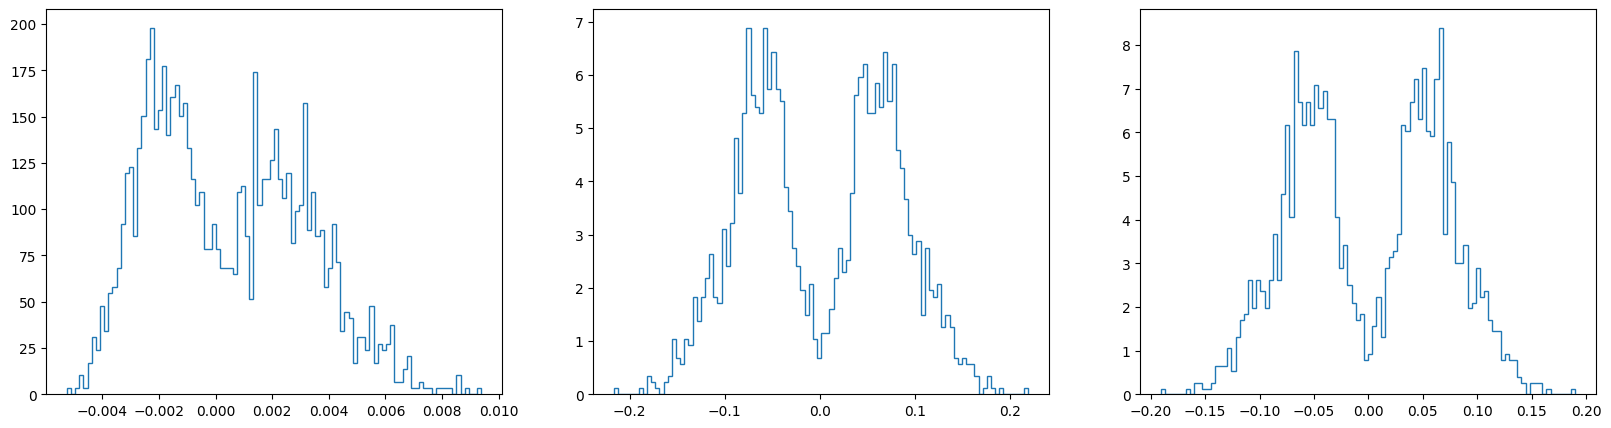

In [50]:
fig = plt.figure(figsize=(20, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(Omega_rot[:,i] - Omega_rot_prog[i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

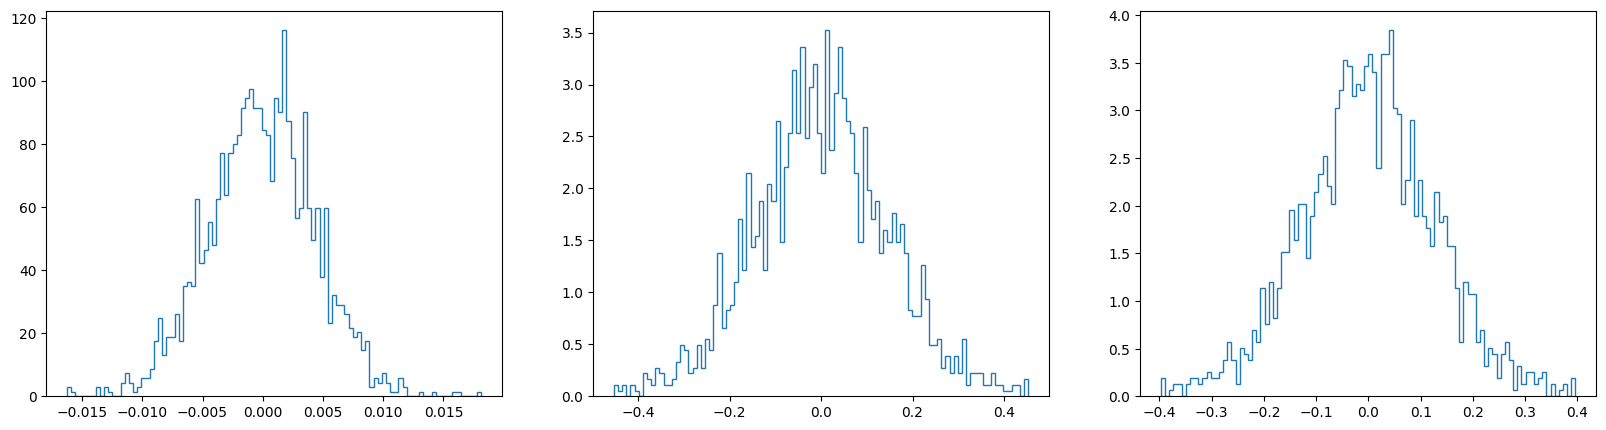

In [52]:
fig = plt.figure(figsize=(20, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(theta_rot[:,i] - theta_rot_prog[i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

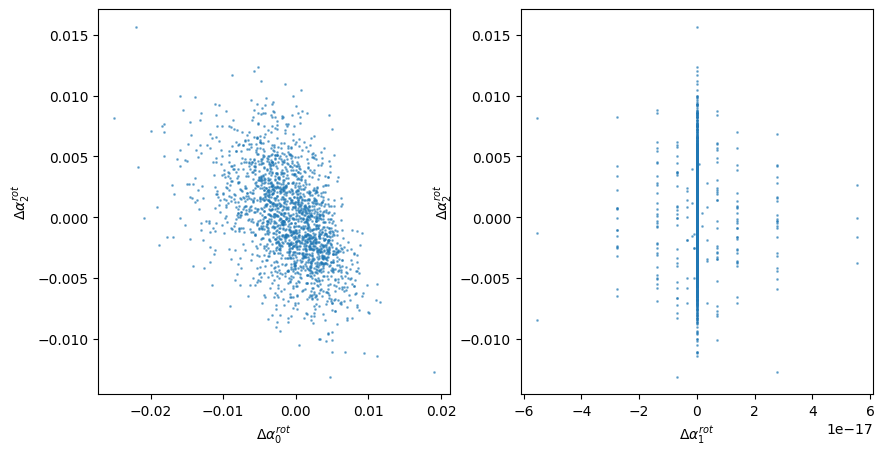

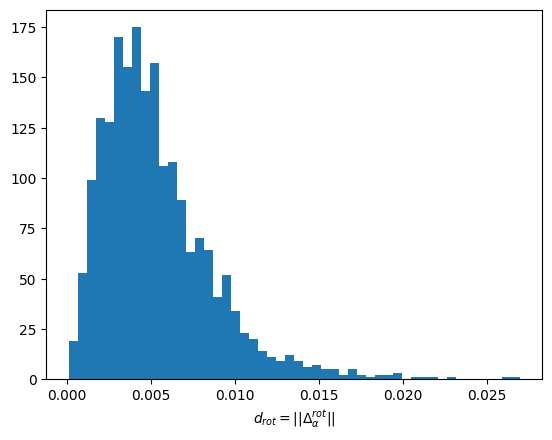

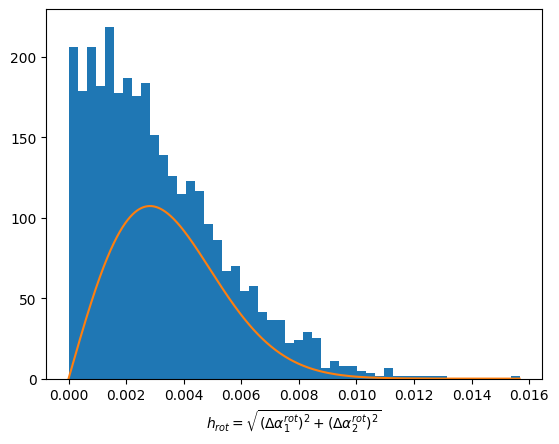

In [65]:
delta_theta_rot = theta_rot - theta_rot_prog
delta_Omega_rot = Omega_rot - Omega_rot_prog
delta_t_rot = delta_theta_rot[:, 1]/delta_Omega_rot[:, 1]
delta_alpha_rot = delta_theta_rot - delta_Omega_rot * delta_t_rot[:, None]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121,)
ax.scatter(delta_alpha_rot[:,0], delta_alpha_rot[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_0^{rot}$')
ax.set_ylabel(r'$\Delta \alpha_2^{rot}$')
ax = fig.add_subplot(122,)
plt.scatter(delta_alpha_rot[:,1], delta_alpha_rot[:,2], s=1, alpha=0.5)
plt.xlabel(r'$\Delta \alpha_1^{rot}$')
plt.ylabel(r'$\Delta \alpha_2^{rot}$')
plt.show()

d_rot = np.linalg.norm(delta_alpha_rot, axis=1)
plt.hist(d_rot, bins=50 );
plt.xlabel(r'$d_{rot} = ||\Delta_\alpha^{rot}||$')
plt.show()

h_rot = np.sqrt(delta_alpha_rot[:, 1]**2 + delta_alpha_rot[:, 2]**2)
plt.hist(h_rot, bins=50, density=True );
plt.xlabel(r'$h_{rot} = \sqrt{(\Delta \alpha_1^{rot})^2 + (\Delta \alpha_2^{rot})^2}$')
h_rot_sort = np.sort(h_rot)
sigma = 0.004
plt.plot(h_rot_sort,  h_rot_sort/sigma**2 * np.exp(-h_rot_sort**2/sigma**2))

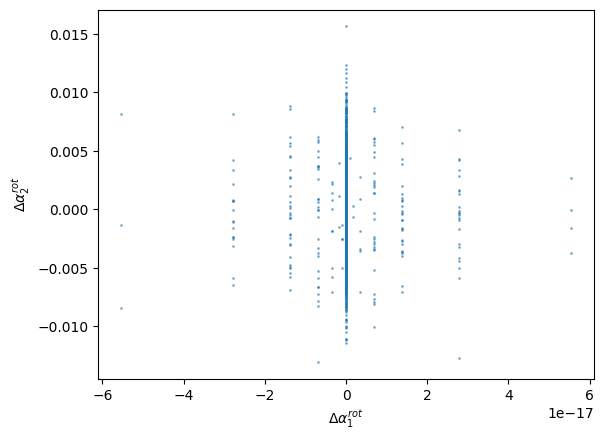

In [54]:
mask = d_rot < 1
plt.scatter(delta_alpha_rot[mask,1], delta_alpha_rot[mask,2], s=1, alpha=0.5)
plt.xlabel(r'$\Delta \alpha_1^{rot}$')
plt.ylabel(r'$\Delta \alpha_2^{rot}$')
plt.show()


In [55]:
delta_alpha_rot.shape

(2000, 3)

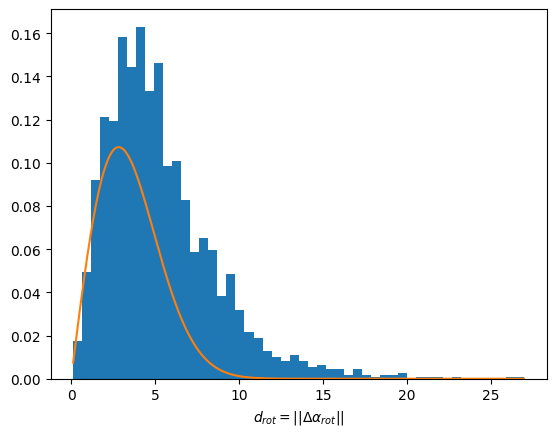

In [63]:
# mask = d_rot < 1
d_rot = np.linalg.norm(delta_alpha_rot, axis=1) * 1000
# d_rot = d_rot[mask]
x = np.sort(d_rot)
sigma = 4
plt.hist(x, density=True, bins=50);
plt.xlabel(r'$d_{rot} = ||\Delta \alpha_{rot}||$')
plt.plot(x,  x/sigma**2 * np.exp(-x**2/sigma**2))
plt.show()

# Gala

In [ ]:
import gala.dynamics as gala_gd
import gala.integrate as gala_gi
import gala.potential as gala_gp
from gala.units import galactic
import astropy.units as u

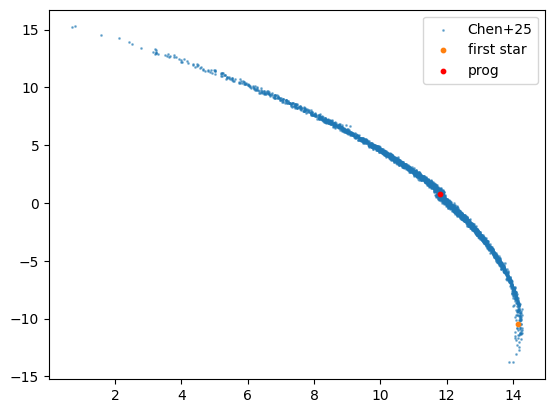

In [ ]:
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, label="Chen+25", alpha=0.5)
plt.scatter(stream_c25.q.x[0].value, stream_c25.q.y[0].value, s=10, label="first star", )
prog_c25_x = prog_c25.q.x.value
prog_c25_y = prog_c25.q.y.value
plt.scatter(np.array(prog_c25_x), np.array(prog_c25_y), s=10, label="prog", color='red')
plt.legend()

In [ ]:
def stream_to_numpyarray(stream):
    pos = np.array([stream.q.x.to('kpc'), stream.q.y.to('kpc'), stream.q.z.to('kpc')])
    vel = np.array([stream.p.x.to('km/s'), stream.p.y.to('km/s'), stream.p.z.to('km/s')])
    return pos, vel
stream_array_pos, stream_array_vel = stream_to_numpyarray(stream_c25)

def prog_to_numpyarray(prog):
    pos = np.array([prog.q.x.to('kpc').value, prog.q.y.to('kpc').value, prog.q.z.to('kpc').value])
    vel = np.array([prog.p.x.to('km/s').value, prog.p.y.to('km/s').value, prog.p.z.to('km/s').value])
    return pos, vel


In [ ]:
stream_array_pos, stream_array_vel = prog_to_numpyarray(prog_c25)

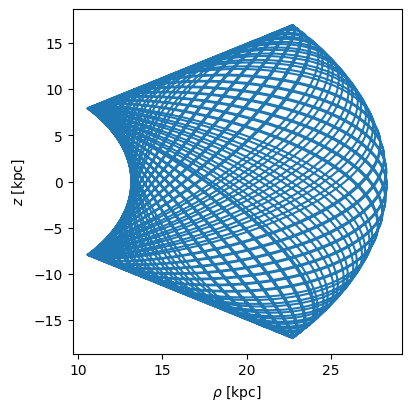

In [ ]:
pot = gala_gp.MilkyWayPotential()
w0 = gala_gd.PhaseSpacePosition(pos=stream_array_pos * u.kpc, 
                                vel=stream_array_vel * u.km/u.s)
w = gala_gp.Hamiltonian(pot).integrate_orbit(w0, dt=0.5, n_steps=50000)
cyl = w.represent_as('cylindrical')
fig = cyl.plot(['rho', 'z'], linestyle='-') 

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()



Text(0, 0.5, '$J_1$ [rad]')

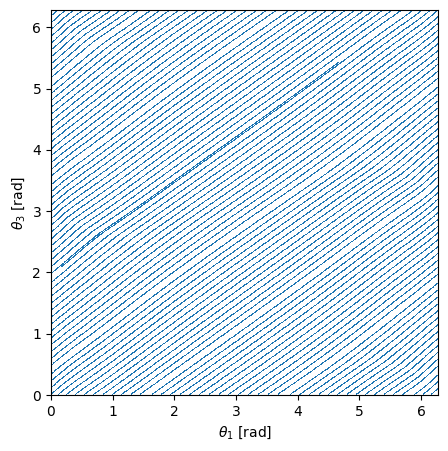

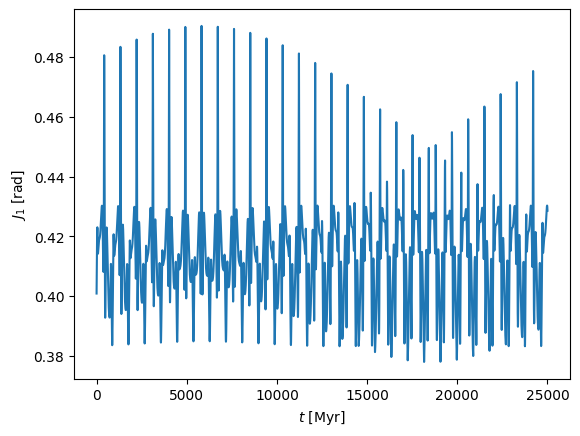

In [ ]:
toy_potential = gala_gd.fit_isochrone(w)
toy_actions,toy_angles,toy_freqs = toy_potential.action_angle(w)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(toy_angles[0], toy_angles[2], linestyle='none', marker=',') 
ax.set_xlim(0,2*np.pi) 
ax.set_ylim(0,2*np.pi) 
ax.set_xlabel(r"$\theta_1$ [rad]") 
ax.set_ylabel(r"$\theta_3$ [rad]") 

fig,ax = plt.subplots(1,1)
ax.plot(w.t, toy_actions[0], marker='') 
ax.set_xlabel(r"$t$ [Myr]") 
ax.set_ylabel(r"$J_1$ [rad]") 


In [ ]:
result = gala_gd.find_actions_o2gf(w, N_max=8, toy_potential=toy_potential) 
result['actions'].to(u.kpc*u.km/u.s)

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:652: UserWarning:

<Quantity [[  403.47605953, -3089.60080744,   808.5705163 ]] km kpc / s>

nvecs shape: (256, 3)
result['Sn'] shape: (1, 256)
toy_angles shape: (3, 50001)


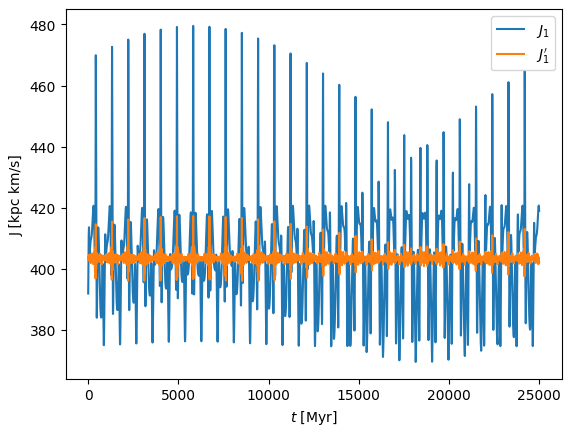

In [ ]:
nvecs = gala_gd.generate_n_vectors(8, dx=1, dy=2, dz=2) 


# Check shapes for debugging
print(f"nvecs shape: {nvecs.shape}")
print(f"result['Sn'] shape: {result['Sn'].shape}")
print(f"toy_angles shape: {toy_angles.shape}")

# Correct broadcasting:
# nvecs: (256, 3) - frequency vectors
# result['Sn']: (3, 256) - action coefficients
# toy_angles: (3, 20001) - angles over time
# nvecs.dot(toy_angles): (256, 20001) - phase for each frequency vector at each time

# Calculate phase for each frequency vector
phases = nvecs.dot(toy_angles)  # shape: (256, 20001)

# Calculate correction for each action component
# nvecs.T: (3, 256) - frequency components for each action
# result['Sn']: (3, 256) - coefficients
# cos(phases): (256, 20001) - time evolution

act_correction = nvecs.T[:, :, None] * result['Sn'][:, :, None] * np.cos(phases)[None, :, :]
# Shape: (3, 256, 20001)

# Sum over frequency vectors (axis=1) to get total correction
action_approx = toy_actions - 2*np.sum(act_correction, axis=1)*u.kpc**2/u.Myr 
# Shape: (3, 20001)

fig,ax = plt.subplots(1,1) 
ax.plot(w.t, toy_actions[0].to(u.km/u.s*u.kpc), marker='', label='$J_1$') 
ax.plot(w.t, action_approx[0].to(u.km/u.s*u.kpc), marker='', label="$J_1'$") 
ax.set_xlabel(r"$t$ [Myr]") 
ax.set_ylabel(r"J [kpc km/s]")  # Fixed unit label
ax.legend()
# plt.savefig('./plot/particlespray_chen25/action_correction_J1.png', dpi=300, bbox_inches='tight')
plt.show()



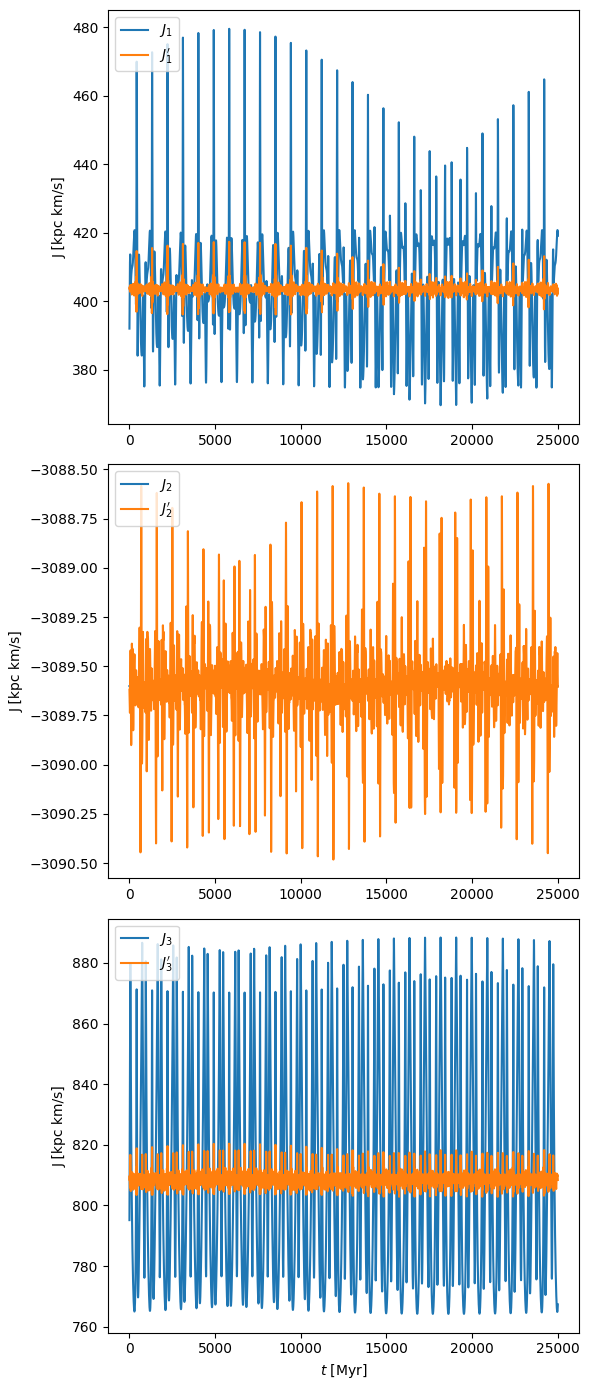

In [ ]:
# for visualization, compute the action correction used to transform the
#   toy potential actions to the approximate true potential actions
nvecs = gala_gd.generate_n_vectors(8, dx=1, dy=2, dz=2)

# Recalculate phases with the new nvecs
phases = nvecs.dot(toy_angles)  # shape: (256, 20001)

# Now the broadcasting will work correctly
# act_correction = nvecs.T[:, :, None] * result['Sn'][:, :, None] * np.cos(phases)[None, :, :]
act_correction = nvecs.T[...,None] * result['Sn'][0][None,:,None] * np.cos(nvecs.dot(toy_angles))[None]
action_approx = toy_actions - 2*np.sum(act_correction, axis=1)*u.kpc**2/u.Myr

fig,axes = plt.subplots(3,1,figsize=(6,14))

for i,ax in enumerate(axes):
    ax.plot(w.t, toy_actions[i].to(u.km/u.s*u.kpc), marker='', label='$J_{}$'.format(i+1))
    ax.plot(w.t, action_approx[i].to(u.km/u.s*u.kpc), marker='', label="$J_{}'$".format(i+1))
    ax.set_ylabel(r"J [kpc km/s]")  # Fixed unit label
    ax.legend(loc='upper left')

ax.set_xlabel(r"$t$ [Myr]")
fig.tight_layout()
plt.show()

# Galpy

In [ ]:
from gala.dynamics.actionangle import get_staeckel_fudge_delta
from galpy.actionAngle import actionAngleStaeckel

w0 = gala_gd.PhaseSpacePosition(pos=stream_array_pos * u.kpc, 
                                    vel=stream_array_vel * u.km/u.s)
orbits = pot.integrate_orbit(
    w0, dt=0.5, n_steps=20000)
galpy_potential = pot.as_interop("galpy")
J = np.zeros((3, orbits.norbits))
Omega = np.zeros((3, orbits.norbits))
for n, orbit in enumerate(orbits.orbit_gen()): 
    o = orbit.to_galpy_orbit()
    delta = get_staeckel_fudge_delta(pot, orbit)
    staeckel = actionAngleStaeckel(pot=galpy_potential, delta=delta)
    af = staeckel.actionsFreqs(o)
    af = np.mean(np.stack(af), axis=1)
    J[:3, n] = af[:3]
    Omega[:3, n] = af[3:]

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()



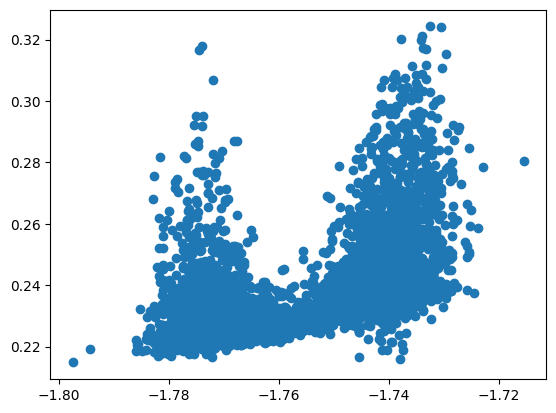

In [ ]:
plt.scatter(J[1], J[0]) 

In [ ]:
stream_array_pos

array([11.799925  ,  0.79013115,  6.400033  ], dtype=float32)